In [ ]:
import pandas as pd
import numpy as np

metricas = {"lineal": {}, "keras": {}}
df = pd.read_csv("boston.csv")
df = df[df["PRICE"] < 50]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

X = df[
    ["RM", "LSTAT", "DIS", "CRIM", "PTRATIO", "NOX", "TAX", "ZN", "INDUS", "AGE", "B"]
]
y = df[["PRICE"]]
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly.fit_transform(X)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=666
)

In [15]:
escaler = StandardScaler()

X_train = escaler.fit_transform(X_train)
X_test = escaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
metricas["lineal"]["MSE"] = mse
metricas["lineal"]["MAE"] = mae
metricas["lineal"]["R2"] = r2
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 12.25035088541236
MAE: 2.605160592693623
R2: 0.8037090355081946


Los residuos no siguen una distribución normal (se rechaza H0)


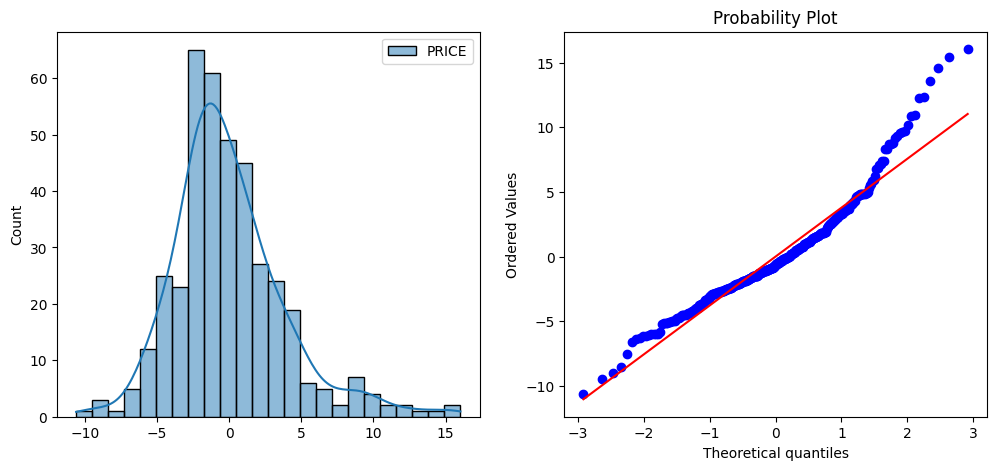

In [ ]:
import seaborn as sns
from scipy.stats import kstest
import matplotlib.pyplot as plt

# ACA BUSCAMOS QUE LOS RESIDUOS SEAN NORMALES
y_pred = modelo.predict(X_train)
residuos = y_train - y_pred
# Test kolmogorov-smirnov
_, p = kstest(residuos.values[:, 0], "norm")
if p > 0.05:
    print("Los residuos siguen una distribución normal (no se rechaza H0)")
else:
    print("Los residuos no siguen una distribución normal (se rechaza H0)")
plt.figure(figsize=(12, 5))
# Usar 2 columnas 1 fila en matplotlib
plt.subplot(1, 2, 1)
# Histograma
sns.histplot(residuos, kde=True)
# Grafico Q-Q
import scipy.stats as stats

plt.subplot(1, 2, 2)
stats.probplot(residuos.values[:, 0], dist="norm", plot=plt)
plt.show()

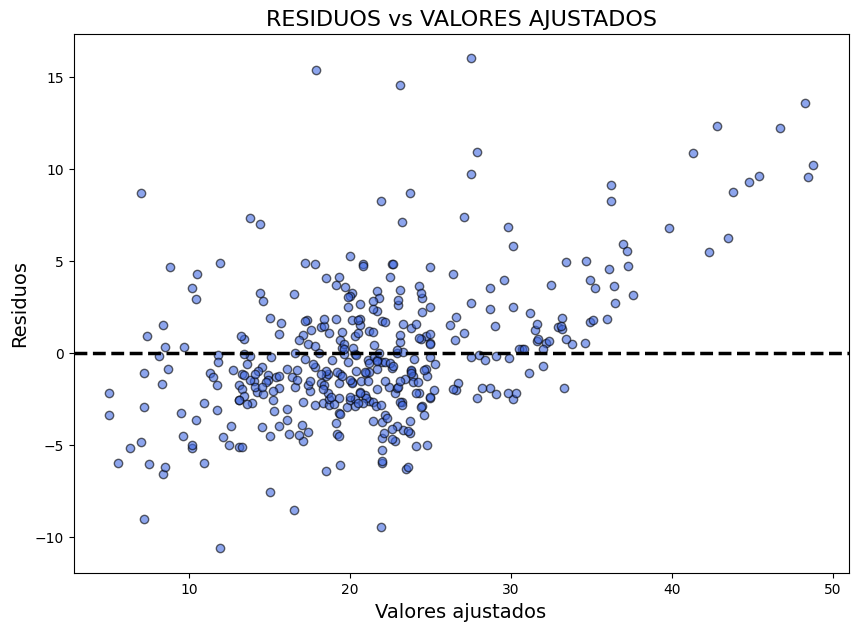

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(x=y_train, y=residuos, alpha=0.6, c="royalblue", edgecolor="black")
plt.axhline(y=0, c="black", ls="--", linewidth=2.5)
plt.title("RESIDUOS vs VALORES AJUSTADOS", fontsize=16)
plt.xlabel("Valores ajustados", fontsize=14)
plt.ylabel("Residuos", fontsize=14)
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# CALLABACKS

callbacks = [
    # 1. Baja el LR si se estanca
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6, verbose=1
    ),
    # 2. Detiene y restaura si no hay remedio
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    # 3. Guarda una copia física solo de los mejores pesos (seguridad extra)
    ModelCheckpoint(
        "best_regresion.weights.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    ),
]


normalizer = layers.Normalization()
normalizer.adapt(X_train)
inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-1), loss="mae", metrics=["mae"])
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 13.2877 - mae: 13.2877 - val_loss: 7.2819 - val_mae: 7.2819 - learning_rate: 0.1000
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0111 - mae: 6.0111 - val_loss: 4.2674 - val_mae: 4.2674 - learning_rate: 0.1000
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1176 - mae: 4.1176 - val_loss: 4.1408 - val_mae: 4.1408 - learning_rate: 0.1000
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7458 - mae: 3.7458 - val_loss: 2.5518 - val_mae: 2.5518 - learning_rate: 0.1000
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0931 - mae: 3.0931 - val_loss: 2.6707 - val_mae: 2.6707 - learning_rate: 0.1000
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6262 - mae: 2.6262 - val_loss: 2.8246 - val_mae: 2.8246 - learning_rate: 0.1000
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7579 - mae: 2.7579 - val_loss: 2.4222 - val_mae: 2.4222 - learning_rate: 0.1000
Epoch 8/50
10

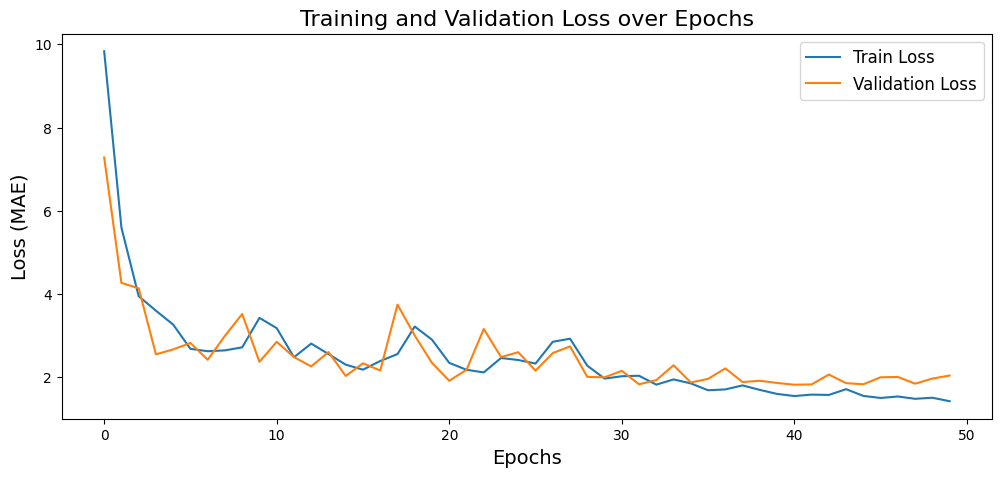

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss (MAE)", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
mae = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"MAE del modelo Keras en el set de prueba: {mae}")
metricas["keras"]["MAE"] = mae
r2 = r2_score(y_test, model.predict(X_test))
print(f"R2 del modelo Keras en el set de prueba: {r2}")
metricas["keras"]["R2"] = r2

MAE del modelo Keras en el set de prueba: 1.7829110622406006
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R2 del modelo Keras en el set de prueba: 0.9110038876533508


In [ ]:
normalizer = layers.Normalization()
normalizer.adapt(X_train)
inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=SGD(learning_rate=1e-1), loss="mae", metrics=["mae"])
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 19.5173 - mae: 19.5173 - val_loss: 5.7728 - val_mae: 5.7728 - learning_rate: 0.1000
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6031 - mae: 6.6031 - val_loss: 3.9398 - val_mae: 3.9398 - learning_rate: 0.1000
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4319 - mae: 4.4319 - val_loss: 2.7857 - val_mae: 2.7857 - learning_rate: 0.1000
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4386 - mae: 4.4386 - val_loss: 9.3679 - val_mae: 9.3679 - learning_rate: 0.1000
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1023 - mae: 6.1023 - val_loss: 5.3770 - val_mae: 5.3770 - learning_rate: 0.1000
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2607 - mae: 5.2607 - val_loss: 4.7921 - val_mae: 4.7921 - learning_rate: 0.1000
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1367 - mae: 5.1367 - val_loss: 5.7988 - val_mae: 5.7988 - learning_rate: 0.1000
Epoch 8/50
10/10

In [ ]:
mae = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"MAE del modelo Keras en el set de prueba: {mae}")
metricas["keras"]["MAE"] = mae
r2 = r2_score(y_test, model.predict(X_test))
print(f"R2 del modelo Keras en el set de prueba: {r2}")
metricas["keras"]["R2"] = r2
mse = model.evaluate(X_test, y_test, verbose=0)[0]
metricas["keras"]["MSE"] = mse
print(f"MSE del modelo Keras en el set de prueba: {mse}")

MAE del modelo Keras en el set de prueba: 1.8676483631134033
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
R2 del modelo Keras en el set de prueba: 0.9050723910331726
MSE del modelo Keras en el set de prueba: 1.8676483631134033


In [38]:
print("COMPARATIVA DE MODELO LINEAL SCIKIT LEARN VS MODELO KERAS")
print(f"Scikit Learn:")
print(f"MSE: {metricas['lineal']['MSE']:.2f}")
print(f"MAE: {metricas['lineal']['MAE']:.2f}")
print(f"R2: {metricas['lineal']['R2']:.2f}")
print(f"Keras:")
print(f"MSE: {metricas['keras']['MSE']:.2f}")
print(f"MAE: {metricas['keras']['MAE']:.2f}")
print(f"R2: {metricas['keras']['R2']:.2f}")

COMPARATIVA DE MODELO LINEAL SCIKIT LEARN VS MODELO KERAS
Scikit Learn:
MSE: 12.25
MAE: 2.61
R2: 0.80
Keras:
MSE: 1.87
MAE: 1.87
R2: 0.91
